## Imports

In [1]:
import gradio as gr
import pandas as pd
import tensorflow as tf
import seaborn as sns
import numpy as np
import spacy
import matplotlib.pyplot as plt

from wordcloud import WordCloud
from timeit import default_timer as timer
from helper_functions import plot_pie_chart, preprocess_text, plot_training_history, preprocess_single_sentence
from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix

/Users/kushagrakesarwani/Documents/Emotion Detection/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/kushagrakesarwani/Documents/Emotion Detection/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DIR= 'kaggle/input/emotion-dataset-for-nlp/'
TRAIN_FILE = 'train.txt'
VAL_FILE = 'val.txt'
TEST_FILE = 'test.txt'

In [3]:
train_df = pd.read_csv(DIR+TRAIN_FILE, delimiter=';', header=None, names=['text', 'label'])
val_df = pd.read_csv(DIR+VAL_FILE, delimiter=';', header=None, names=['text', 'label'])
test_df = pd.read_csv(DIR+TEST_FILE, delimiter=';', header=None, names=['text', 'label'])

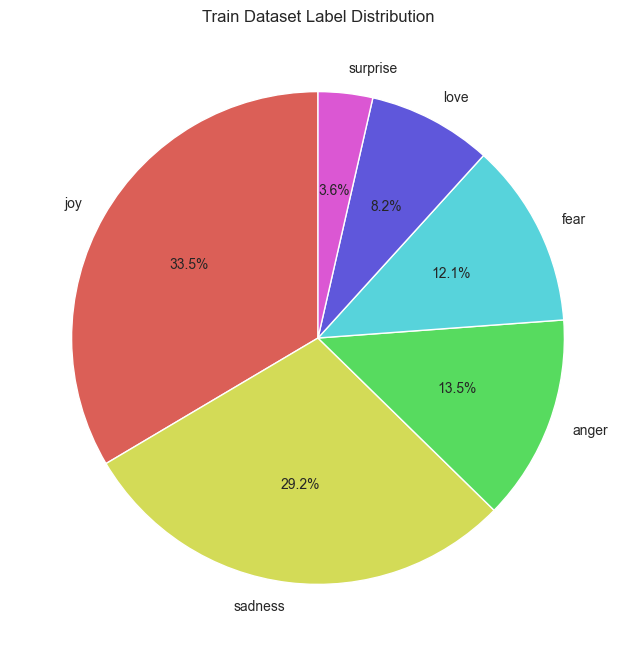

In [4]:
plot_pie_chart(train_df, 'Train Dataset')

In [5]:
train_df['label'].value_counts()

label
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64

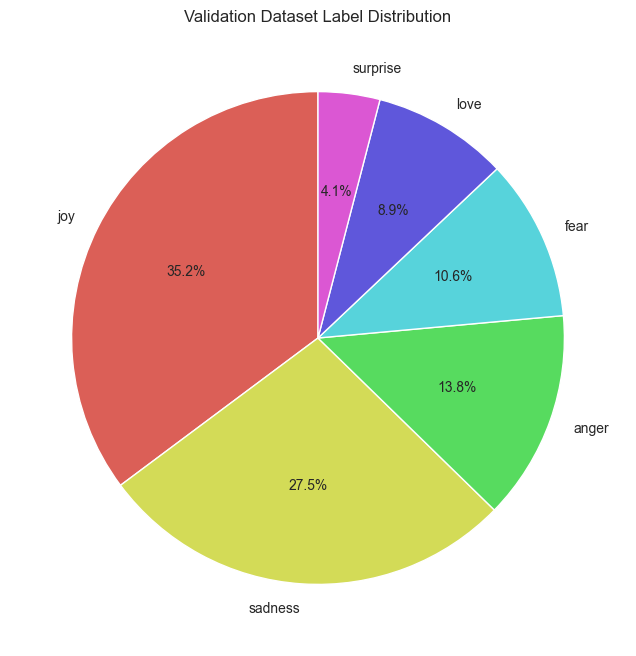

In [6]:
plot_pie_chart(val_df, 'Validation Dataset')

## Preprocessing

In [7]:
# joy= train_df[train_df['label']== 'joy'].sample(n=2000)
# anger= train_df[train_df['label']== 'anger'].sample(n=2000)
# sadness= train_df[train_df['label']== 'sadness'].sample(n=2000)
# fear= train_df[train_df['label']== 'fear'].sample(n=1937)

# del(train_df)
# train_df= pd.concat([joy, anger, sadness, fear], ignore_index=True)
# train_df= train_df.sample(frac=1).reset_index(drop=True)

In [8]:
# plot_pie_chart(train_df, 'New Train Dataset')

In [9]:
%%writefile helper_functions.py
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import spacy

with open('kaggle/label_names.txt', 'r') as f:
    labels = [emotion.strip() for emotion in f.readlines()]

encoder= LabelEncoder()
encoder.fit(labels)

nlp = spacy.load("en_core_web_sm")


def plot_pie_chart(data_frame: pd.DataFrame, title: str) -> None:
    """
    Plot a pie chart to visualize label distribution in the provided DataFrame.

    Args:
        data_frame (pd.DataFrame): The DataFrame containing the data to visualize.
        title (str): The title for the pie chart.

    Returns:
        None
    """
    label_count = data_frame['label'].value_counts()
    plt.figure(figsize=(8, 8))
    sns.set_style("whitegrid")
    plt.pie(label_count, labels=label_count.index, colors=sns.color_palette("hls", len(label_count.index)), autopct='%1.1f%%', startangle=90)
    plt.title(f"{title} Label Distribution")
    plt.show()
    plt.close()

def preprocess_text(df: pd.DataFrame, emotions: list=['love', 'surprise']):
    """
    Preprocesses text data in a DataFrame.

    Args:
        df (pd.DataFrame): DataFrame containing 'text' and 'label' columns.
        emotions (list): List of emotions to drop from the DataFrame.

    Returns:
        pd.DataFrame: DataFrame with preprocessed text and encoded labels.
    # """
    for i in emotions:
        df = df[df['label'] != i]

    df['processed_text'] = df['text'].apply(lambda x: ' '.join([token.lemma_ for token in nlp(x) if not token.is_stop and not token.is_punct and not token.is_space]))

    df['label_num'] = encoder.transform(df['label'])
    df.drop(columns=['text', 'label'], inplace=True)
    return df

def preprocess_single_sentence(sentence):
    """
    Preprocesses a single sentence.

    Args:
        sentence (str): Input sentence.

    Returns:
        str: Preprocessed and tokenized sentence.
    """
    processed_text = ' '.join([token.lemma_ for token in nlp(sentence) if not token.is_stop and not token.is_punct and not token.is_space])
    return processed_text

def plot_training_history(history):
    """
    Plots the training and validation accuracy and loss curves.

    Parameters:
    history (History object): History object returned by model.fit() containing training metrics.

    Returns:
    None
    """
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()


Overwriting helper_functions.py


In [10]:
train_df= preprocess_text(train_df)
val_df= preprocess_text(val_df)

## Visualisation

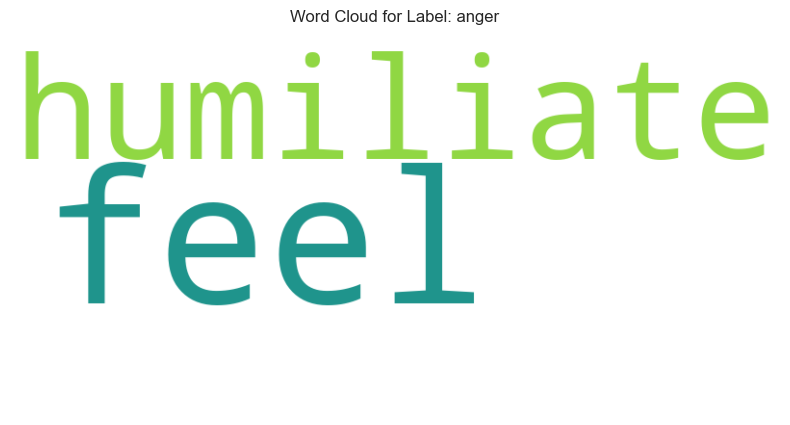

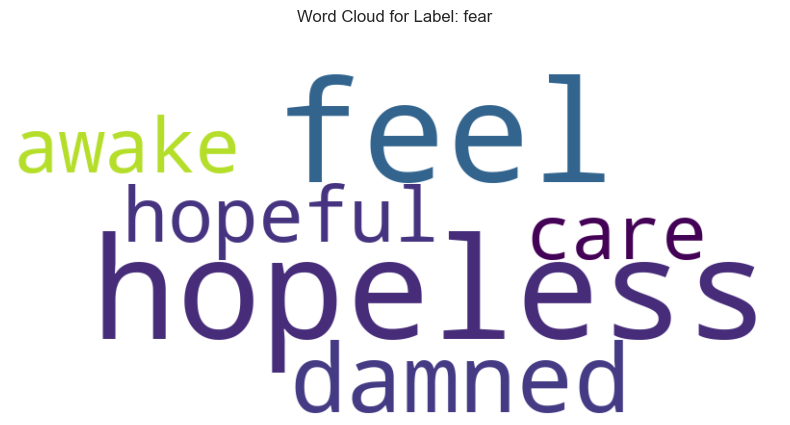

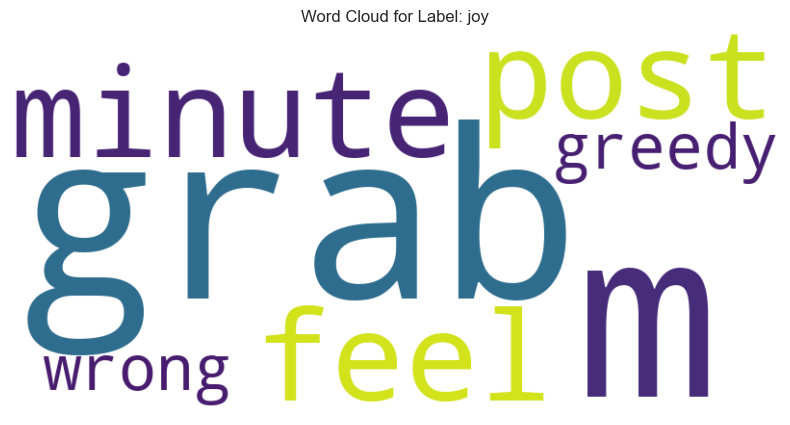

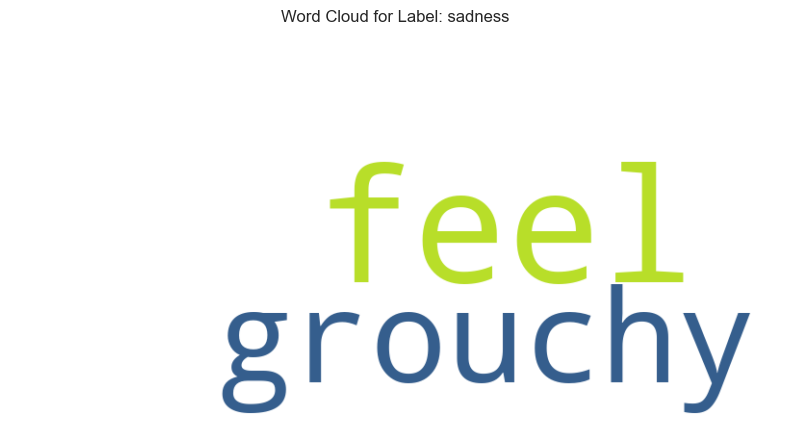

In [11]:
with open('kaggle/label_names.txt', 'r') as f:
    labels = [emotion.strip() for emotion in f.readlines()] 

# Generate and plot word cloud for each label
for class_label, text in zip(labels, train_df['processed_text']):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for Label: {class_label}')
    plt.axis('off')
    plt.show()


## Model

In [12]:
VOCAB_SIZE= 11000
text_vect_layer= tf.keras.layers.TextVectorization(max_tokens= VOCAB_SIZE)
text_vect_layer.adapt(train_df['processed_text'])

In [13]:
EMBEDDING_UNITS= 64
UNITS= 64
DROPOUT= 0.2

model_v1= tf.keras.Sequential([
    text_vect_layer,
    layers.Embedding(input_dim=text_vect_layer.vocabulary_size(), output_dim= EMBEDDING_UNITS, mask_zero= True),
    # layers.GRU(UNITS, dropout= DROPOUT, return_sequences= True),
    layers.GRU(UNITS, dropout= DROPOUT),
    layers.Dense(len(labels), activation= 'sigmoid')
])

model_v2= tf.keras.Sequential([
    text_vect_layer,
    layers.Embedding(input_dim=text_vect_layer.vocabulary_size(), output_dim= EMBEDDING_UNITS, mask_zero= True),
    layers.GRU(UNITS, dropout= DROPOUT, return_sequences= True),
    layers.GRU(UNITS, dropout= DROPOUT),
    layers.Dense(len(labels), activation= 'softmax')
])


In [14]:
model_v1.compile(optimizer= tf.keras.optimizers.Adam(),
                 loss= tf.keras.losses.SparseCategoricalCrossentropy(),
                 metrics=['accuracy'])
model_v2.compile(optimizer= tf.keras.optimizers.Adam(),
                 loss= tf.keras.losses.SparseCategoricalCrossentropy(),
                 metrics=['accuracy'])

In [15]:
BATCH_SIZE= 32  
train_set= tf.data.Dataset.from_tensor_slices((train_df['processed_text'].values, train_df['label_num'].values)).batch(BATCH_SIZE)
val_set= tf.data.Dataset.from_tensor_slices((val_df['processed_text'].values, val_df['label_num'].values)).batch(BATCH_SIZE)

In [16]:
history_model_v1= model_v1.fit(train_set, validation_data= val_set, epochs= 5)

Epoch 1/5
442/442 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5508 - loss: 1.0442 - val_accuracy: 0.9351 - val_loss: 0.1835
Epoch 2/5
442/442 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9527 - loss: 0.1418 - val_accuracy: 0.9500 - val_loss: 0.1347
Epoch 3/5
442/442 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9786 - loss: 0.0632 - val_accuracy: 0.9495 - val_loss: 0.1379
Epoch 4/5
442/442 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9857 - loss: 0.0459 - val_accuracy: 0.9483 - val_loss: 0.1574
Epoch 5/5
442/442 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9889 - loss: 0.0326 - val_accuracy: 0.9495 - val_loss: 0.1788


In [17]:
history_model_v2= model_v2.fit(train_set, validation_data= val_set, epochs= 5)

Epoch 1/5
442/442 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.5510 - loss: 1.0078 - val_accuracy: 0.9408 - val_loss: 0.1774
Epoch 2/5
442/442 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9496 - loss: 0.1450 - val_accuracy: 0.9512 - val_loss: 0.1504
Epoch 3/5
442/442 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9796 - loss: 0.0635 - val_accuracy: 0.9397 - val_loss: 0.1815
Epoch 4/5
442/442 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9859 - loss: 0.0427 - val_accuracy: 0.9357 - val_loss: 0.2002
Epoch 5/5
442/442 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9880 - loss: 0.0343 - val_accuracy: 0.9414 - val_loss: 0.2117


## Evaluating the model

In [18]:
test_df= preprocess_text(test_df)
test_set= tf.data.Dataset.from_tensor_slices((test_df['processed_text'].values, test_df['label_num'].values)).batch(BATCH_SIZE)

In [19]:
eval_model_v1= model_v1.evaluate(test_set)
eval_model_v2= model_v2.evaluate(test_set)

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9418 - loss: 0.1872
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9434 - loss: 0.2074


## Plotting the losses and accuracy

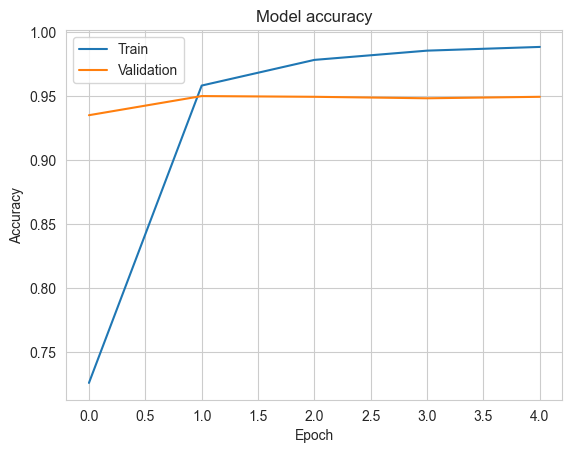

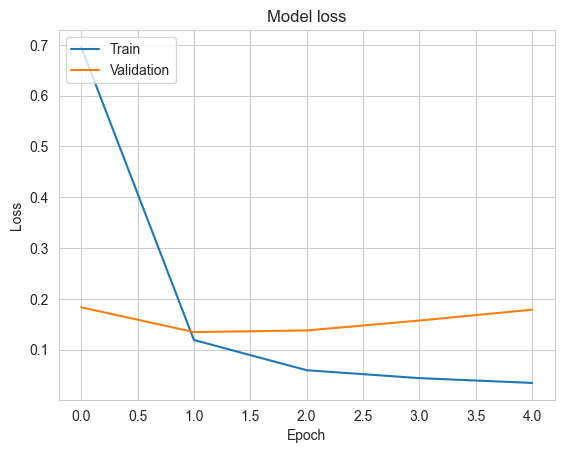

In [31]:
plot_training_history(history_model_v1)

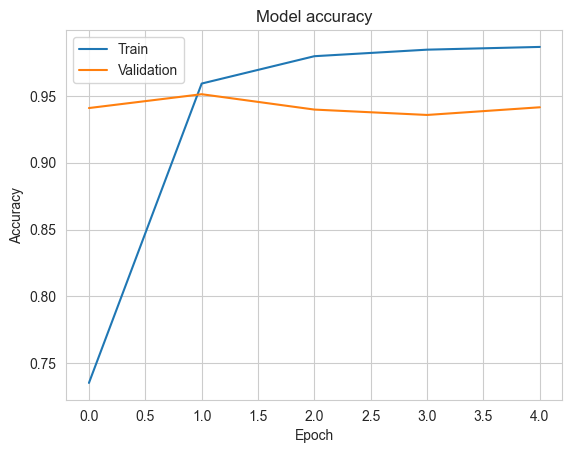

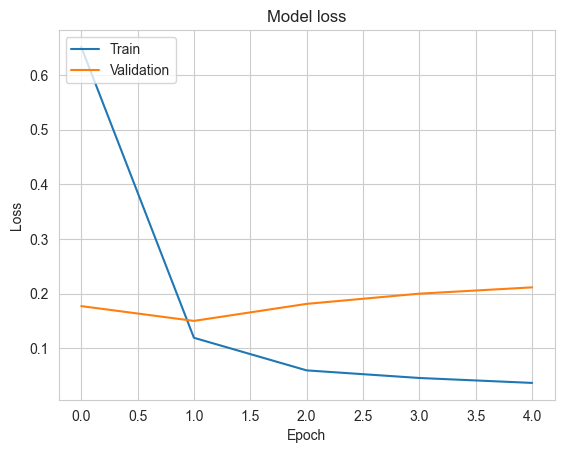

In [32]:
plot_training_history(history_model_v2)

In [21]:
test_df.reset_index(drop=True, inplace=True)
test_df

,processed_text,label_num
0,m feel rotten m ambitious right,3
1,m update blog feel shitty,3
2,separate don t want feel like m ashamed,3
3,leave bouquet red yellow tulip arm feel slight...,2
4,feel little vain,3
...,...,...
1770,feel like unkind wrong think people close,0
1771,m feel little cranky negative doctor appointment,0
1772,feel useful people give great feeling achievement,2
1773,m feel comfortable derby feel start step shell,2


## Evaluate the model

In [22]:
def evaluate_true_vs_predicted(true_labels, predicted_labels):
    """
    Evaluates the true versus predicted labels using accuracy and confusion matrix.

    Parameters:
    true_labels (numpy array): Array containing true labels.
    predicted_labels (numpy array): Array containing predicted labels.

    Returns:
    accuracy (float): Accuracy of the predictions.
    confusion_mat (numpy array): Confusion matrix.
    """
    accuracy = accuracy_score(true_labels, predicted_labels)
    confusion_mat = confusion_matrix(true_labels, predicted_labels)
    return accuracy, confusion_mat

true_labels= test_df['label_num']
pred_labels= []
for i in range(len(true_labels)):
    sample_text= test_df['processed_text'][i]
    sample_text= tf.expand_dims(sample_text, 0)
    prob= model_v1.predict(sample_text)
    prob= prob[0]
    pred_label= np.argmax(prob)
    pred_labels.append(pred_label)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/

In [23]:
accuracy, confusion_mat = evaluate_true_vs_predicted(true_labels, predicted_labels=pred_labels)
print("Accuracy:", accuracy)

Accuracy: 0.9464788732394366


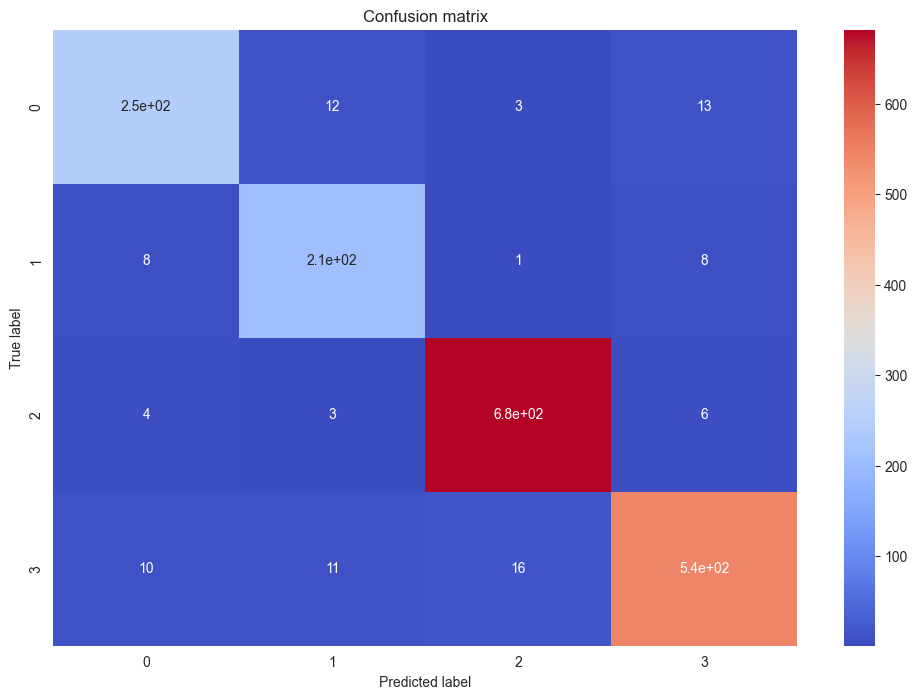

In [24]:
plt.figure(figsize=(12,8))
sns.heatmap(confusion_mat, annot=True, cmap='coolwarm')
plt.title('Confusion matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [29]:
comparison_df = pd.DataFrame({
    'True_Label': encoder.inverse_transform(true_labels),
    'Predicted_Label': encoder.inverse_transform(pred_labels),
    'Text': test_df['processed_text'] 
})

wrong_predictions_df = comparison_df[comparison_df['True_Label'] != comparison_df['Predicted_Label']]

print("Wrongly Predicted Labels vs. True Labels:")
wrong_predictions_df

Wrongly Predicted Labels vs. True Labels:


,True_Label,Predicted_Label,Text
10,fear,anger,don t feel particularly agitated
12,fear,sadness,pay attention deepen feeling invade helpless
19,sadness,fear,m sure feeling loss away dull sweet feeling no...
65,anger,sadness,feel bit stress thing go fun
90,anger,fear,feel heart torture
...,...,...,...
1711,fear,sadness,feel inside cause life like game come wall dis...
1718,fear,anger,ve start feel like worth get agitated
1725,sadness,anger,didn t mean angry bommie t control feeling hel...
1739,joy,anger,check sleep feel nose toe sure aren t hot cold


## Saving the model

In [30]:
gru_model= 'models/gru_model.keras'
soft_max= 'models/gru_model_softmax.keras'
model_v1.save(gru_model)
model_v2.save(soft_max)

## Predictions for a single sentence
To make predictions on a single sentence, we need to do the following steps:
1. Process it in the same manner to remove the extra token words such (as punctuations)
2. Expand the dimension.
3. Pass through the model.

In [ ]:
with open('kaggle/examples.txt', 'r') as f:
    example_list = [example.strip() for example in f.readlines()]

encoder= LabelEncoder()
encoder.fit(labels) 

model = tf.keras.models.load_model(gru_model)

nlp = spacy.load("en_core_web_sm")

def predict(text):
    """
    Make predictions on the given text using the trained model.

    Args:
        text (str): The text to make predictions on.

    Returns:
        list: A list of predictions.
    """
    start_time= timer()
    text= preprocess_single_sentence(text)
    text= tf.expand_dims(text, 0)

    probability = model.predict(text)
    pred_label_with_prob= {labels[i]: float(probability[0][i]) for i in range(len(labels))} 
    pred_time = round(timer() - start_time, 5)
    return pred_label_with_prob, pred_time

### Gradio App
input= gr.Textbox(lines=5, label="Enter text", placeholder="i like to have the same breathless feeling as a reader eager to see what will happen next")
outputs=[
        gr.Label(num_top_classes=len(labels), label="Predictions"),
        gr.Number(label="Prediction time (s)"),
    ]
title= ' Sentiment Analysis 🤣😱😡😢 '
description= 'The sentiment analysis model is a deep learning-based natural language processing (NLP) model designed to analyze and classify the sentiment expressed in text data. It is trained to understand the emotional tone of text and categorize it into predefined sentiment categories such as <b>anger, fear, saddness and joy.<b>'
demo= gr.Interface(fn=predict, 
                   inputs=input, 
                   outputs=outputs, 
                   title=title, 
                   description=description,
                   examples= example_list
                  )
demo.launch()

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


2024-03-19 18:15:18.528693: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Tried to stack list which only contains uninitialized tensors and has a non-fully-defined element_shape: [?,64]
	 [[{{node sequential_1/gru_1/TensorArrayV2Stack/TensorListStack}}]]
2024-03-19 18:15:18.529882: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at strided_slice_op.cc:117 : INVALID_ARGUMENT: slice index 0 of dimension 0 out of bounds.
Traceback (most recent call last):
  File "/Users/kushagrakesarwani/Documents/Emotion Detection/.venv/lib/python3.9/site-packages/gradio/queueing.py", line 501, in call_prediction
    output = await route_utils.call_process_api(
  File "/Users/kushagrakesarwani/Documents/Emotion Detection/.venv/lib/python3.9/site-packages/gradio/route_utils.py", line 253, in call_process_api
    output = await app.get_blocks().process_api(
  File "/Users/kushagrakesarwani/Documents/Emotion Detection/.venv

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
